In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

pd.set_option('display.max_columns', 1000)

In [3]:
data = pd.read_parquet("../player_stats_2020.parquet")#player stats from rbdm github
cpoe_epa = pd.read_csv("../2009-2019cpoe_epa.csv")#epa/cpoe from rbdm site 

In [4]:
#selecting for just quarterbacks and the columns name, team and week 
qb_data = data[data['passing_yards'] > 50][['player_name', 'recent_team', 'week']]

In [5]:
#selecting for just name and EPA + cpoe
trim_qb_epa = cpoe_epa[['Player', 'EPA+CPOE composite']]

In [6]:
#renaming columns
trim_qb_epa.rename(columns= {'Player':'player_name','EPA+CPOE composite':'epa+cpoe'}, inplace= True)

/Users/aidancoco/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [7]:
#rectifying a discrepancy where one dataset had player name in a different format 
trim_qb_epa.player_name = trim_qb_epa.player_name.astype('str')
qb_data.player_name = qb_data.player_name.astype('str')


/Users/aidancoco/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [8]:
#merging week by week qb data with epa/cpoe data 
cpoe_epa_weekly_data = trim_qb_epa.merge(qb_data)

In [9]:
cpoe_epa_weekly_data.size

1892

In [10]:
betting_data = pd.read_csv('../nfl_data/spreadspoke_scores.csv')#betting data from kaggle 

In [11]:
betting_data = betting_data[betting_data.schedule_playoff == False]

In [12]:
#selecting the spread, which team was favored, week, home/away team, home/ away score
#only from the 2021 season 
betting_data = betting_data[betting_data.schedule_season == 2020][['spread_favorite','team_favorite_id','schedule_week',
                                                                   'team_home', 'team_away', 'score_away', 'score_home']]

In [13]:
#resetting the index of this smaller dataframe 
betting_data.reset_index(inplace= True)

In [14]:
#dropping the old index 
betting_data.drop('index', axis = 1,inplace= True)

In [15]:
#importing ID data to make the team names the same format as my other data
id_data = pd.read_csv('../nfl_teams.csv')

In [16]:
#simplyfing to only the needed columns 
id_data = id_data[['Name', 'Abbreviation']]

In [17]:
#changing "New York" to 'NY'
id_data['Name'] = id_data.Name.replace(['NY Giants', 'NY Jets'], ['New York Giants', 'New York Jets'])

In [18]:
#makinga function to fetch the name from one the names data set and update the betting data dataset 
def change_to_abrev(name):
    return id_data[id_data.Name == name]['Abbreviation'].values[0]

In [19]:
#implementing the function
betting_data.team_away = betting_data['team_away'].apply(lambda x: change_to_abrev(x))
betting_data.team_home = betting_data['team_home'].apply(lambda x: change_to_abrev(x))

In [20]:
betting_data.head()

,spread_favorite,team_favorite_id,schedule_week,team_home,team_away,score_away,score_home
0,-9.0,KC,1,KC,HOU,20,34
1,-1.0,SEA,1,ATL,SEA,38,25
2,-7.0,BAL,1,BAL,CLE,6,38
3,-6.5,BUF,1,BUF,NYJ,17,27
4,-3.0,LVR,1,CAR,LV,34,30


In [21]:
#adding a variable that checks whether the home team won 
betting_data['home_win'] = betting_data['score_home'] > betting_data['score_away']

In [22]:
#making a simple function to check if the home team was the favorite
def home_favorite(x, y):
    return x == y

In [23]:
#implementing the function in a new column 
betting_data['home_favorite'] = betting_data.apply(lambda x: home_favorite(x['team_home'], x['team_favorite_id']), axis =1)

In [24]:
#adding a margin of victory column to the data 
betting_data['mov'] = abs(betting_data['score_away'] - betting_data['score_home'])

In [25]:
#creating a function to see which team covered 
def cover (spread, home_win, home_favorite, mov, home, away):
    if (home_win) & (home_favorite) & (mov>abs(spread)):
        return home
    elif (home_win) & (home_favorite) & (mov<abs(spread)):
        return away
    elif (home_win) & (home_favorite == False):
        return home
    elif (home_win == False)& (home_favorite):
        return away
    elif (home_win == False) & (home_favorite == False) & (mov>abs(spread)):
        return away 
    elif (home_win == False) & (home_favorite == False) & (mov<abs(spread)):
        return home

In [26]:
#implementing the cover function in a new column 
betting_data['cover'] = betting_data.apply(lambda row: cover(row['spread_favorite'], row['home_win'], row['home_favorite'], 
                                                             row['mov'], row['team_home'], row['team_away']), axis =1)

In [27]:
betting_data['schedule_week'] = betting_data.schedule_week.astype(int)

In [28]:
#creating a function to get the rating from the cpoe dataset
def qb_rating(team, week):
    results = cpoe_epa_weekly_data[(cpoe_epa_weekly_data.week == week)&(cpoe_epa_weekly_data.recent_team == team)]['epa+cpoe'].values
    if len(results) > 0:
        return results[0]
    else:
        return None
        

In [29]:
betting_data['home_qb'] = betting_data.apply(lambda row: qb_rating(row['team_home'], row['schedule_week']), axis = 1)

In [30]:
betting_data['away_qb'] = betting_data.apply(lambda row: qb_rating(row['team_away'], row['schedule_week']), axis = 1)

In [31]:
betting_data

,spread_favorite,team_favorite_id,schedule_week,team_home,team_away,score_away,score_home,home_win,home_favorite,mov,cover,home_qb,away_qb
0,-9.0,KC,1,KC,HOU,20,34,True,True,14,KC,0.188,0.134
1,-1.0,SEA,1,ATL,SEA,38,25,False,False,13,SEA,0.126,0.142
2,-7.0,BAL,1,BAL,CLE,6,38,True,True,32,BAL,0.140,0.068
3,-6.5,BUF,1,BUF,NYJ,17,27,True,True,10,BUF,0.037,0.038
4,-3.0,LVR,1,CAR,LV,34,30,False,False,4,LV,0.068,0.067
5,-3.0,LAC,1,CIN,LAC,16,13,False,False,3,None,NaN,0.078
6,-2.5,DET,1,DET,CHI,27,23,False,True,4,CHI,0.074,0.052
7,-8.0,IND,1,JAX,IND,20,27,True,False,7,JAX,NaN,0.139
8,-2.0,DAL,1,LAR,DAL,17,20,True,False,3,LAR,NaN,0.112
9,-2.5,MIN,1,MIN,GB,43,34,False,True,9,GB,0.107,0.149


In [32]:
condensed = betting_data.dropna()

In [33]:
condensed.head()

,spread_favorite,team_favorite_id,schedule_week,team_home,team_away,score_away,score_home,home_win,home_favorite,mov,cover,home_qb,away_qb
0,-9.0,KC,1,KC,HOU,20,34,True,True,14,KC,0.188,0.134
1,-1.0,SEA,1,ATL,SEA,38,25,False,False,13,SEA,0.126,0.142
2,-7.0,BAL,1,BAL,CLE,6,38,True,True,32,BAL,0.140,0.068
3,-6.5,BUF,1,BUF,NYJ,17,27,True,True,10,BUF,0.037,0.038
4,-3.0,LVR,1,CAR,LV,34,30,False,False,4,LV,0.068,0.067


In [34]:
def qb_getting_points (home_qb, away_qb, home_favorite):
    if (home_qb < away_qb) & (home_favorite):
        return True
    if (home_qb> away_qb)&(home_favorite == False):
        return True 
    else:
        return False 

In [35]:
condensed['qb_getting_points'] = condensed.apply(lambda row: qb_getting_points(row['home_qb'], row['away_qb'], row['home_favorite']), axis = 1)

/Users/aidancoco/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [36]:
condensed[condensed.qb_getting_points == True]

,spread_favorite,team_favorite_id,schedule_week,team_home,team_away,score_away,score_home,home_win,home_favorite,mov,cover,home_qb,away_qb,qb_getting_points
3,-6.5,BUF,1,BUF,NYJ,17,27,True,True,10,BUF,0.037,0.038,True
4,-3.0,LVR,1,CAR,LV,34,30,False,False,4,LV,0.068,0.067,True
9,-2.5,MIN,1,MIN,GB,43,34,False,True,9,GB,0.107,0.149,True
19,-3.5,DAL,2,DAL,ATL,39,40,True,True,1,ATL,0.112,0.126,True
24,-5.5,BUF,2,MIA,BUF,31,28,False,False,3,MIA,0.075,0.037,True
33,-5.5,ARI,3,ARI,DET,26,23,False,True,3,DET,0.056,0.074,True
40,-2.5,TEN,3,MIN,TEN,31,30,False,False,1,MIN,0.107,0.070,True
47,-3.0,BAL,3,BAL,KC,34,20,False,True,14,KC,0.140,0.188,True
49,-3.0,ARI,4,CAR,ARI,21,31,True,False,10,CAR,0.068,0.056,True
55,-3.0,BUF,4,LV,BUF,30,23,False,False,7,BUF,0.067,0.037,True


In [37]:
#if cover == home qb and home qb > away qb 
#if cover == away and and away > homeqb

In [38]:
def did_they_cover(cover, home_team, away_team, home_qb, away_qb):
    if (home_qb > away_qb) & (cover == home_team):
        return True
    if (away_qb > home_qb) & (cover == away_team):
        return True
    else:
        return False

In [39]:
condensed['did_they_cover'] = condensed.apply(lambda row: did_they_cover(row['cover'], row['team_home'], row['team_away'], row['home_qb'], row['away_qb']), axis = 1)

/Users/aidancoco/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [40]:
condensed_only_getpt = condensed[condensed.qb_getting_points == True]

In [41]:
condensed_only_getpt.groupby('did_they_cover').count()/len(condensed_only_getpt)

,spread_favorite,team_favorite_id,schedule_week,team_home,team_away,score_away,score_home,home_win,home_favorite,mov,cover,home_qb,away_qb,qb_getting_points
did_they_cover,,,,,,,,,,,,,,
False,0.342857,0.342857,0.342857,0.342857,0.342857,0.342857,0.342857,0.342857,0.342857,0.342857,0.342857,0.342857,0.342857,0.342857
True,0.657143,0.657143,0.657143,0.657143,0.657143,0.657143,0.657143,0.657143,0.657143,0.657143,0.657143,0.657143,0.657143,0.657143


In [42]:
len(condensed_only_getpt)

35

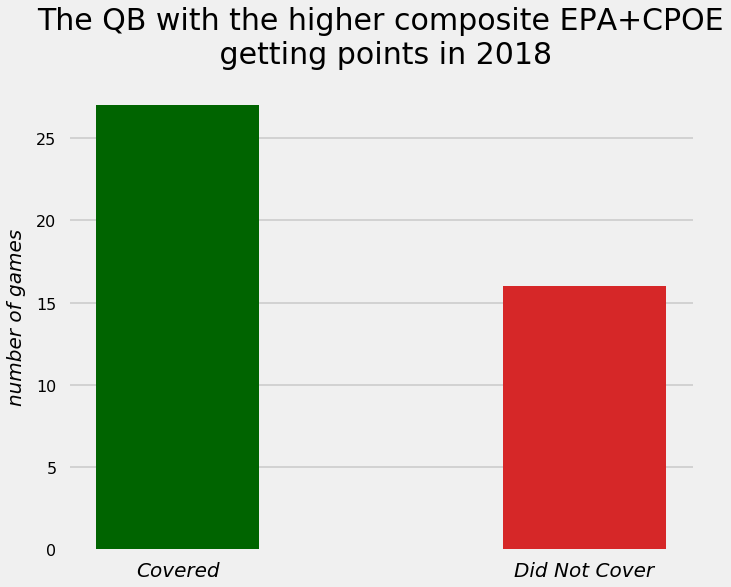

In [43]:
plt.style.use(['fivethirtyeight']) #making my graphs look purd..ier
plt.style.use(['seaborn-poster'])
plt.figure(figsize = (10, 8))#figsize
colors = ('DARKGREEN', 'tab:red')#custom color palletes 
# using the value counts queries and labels in an easier to manipulate(for me) list 
outcome = ['Covered', 'Did Not Cover']
count = [27, 16]
plt.bar(outcome, count, color= colors, width =.4)#plotting
plt.title('The QB with the higher composite EPA+CPOE\n getting points in 2018', size = 30, pad = 20, loc = 'center')#title
#style tweaks
plt.ylabel("number of games", size = 20, labelpad = 10, style = 'italic')
plt.xticks(style = 'italic', size = 20)
plt.grid(axis = 'x')

In [44]:
condensed.to_csv("data/better_qb_2020.csv", index= False)